In [1]:
from matplotlib import pyplot as plt
import seaborn as sns

## Import Dataset

In [2]:
import kagglehub

# Download SARTAJ Dataset
ds_4class_path = kagglehub.dataset_download("sartajbhuvaji/brain-tumor-classification-mri")

print("Path to dataset files:", ds_4class_path)

Using Colab cache for faster access to the 'brain-tumor-classification-mri' dataset.
Path to dataset files: /kaggle/input/brain-tumor-classification-mri


In [3]:
# Download latest version
ds_2class_path = kagglehub.dataset_download("navoneel/brain-mri-images-for-brain-tumor-detection")

print("Path to dataset files:", ds_2class_path)

Using Colab cache for faster access to the 'brain-mri-images-for-brain-tumor-detection' dataset.
Path to dataset files: /kaggle/input/brain-mri-images-for-brain-tumor-detection


## Exploratory Data Analysis

In [4]:

import os

os.listdir(ds_4class_path)

['Training', 'Testing']

In [5]:
def count_images(dir_path):
    count = 0
    for root, dirs , files in os.walk(dir_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                count += 1
    return count

### Brain Tumor Dataset with 2 Classes

In [6]:
import pandas as pd

yes_dir = os.path.join(ds_2class_path, 'yes')
no_dir = os.path.join(ds_2class_path, 'no')

# Create dataframe for 2-class dataset
data_2class = {'Directory': ['yes', 'no'],
               'Number of Images': [count_images(yes_dir), count_images(no_dir)]}
df_2class = pd.DataFrame(data_2class)

print("\nImage distribution in the 2-class dataset:")
display(df_2class)


Image distribution in the 2-class dataset:


,Directory,Number of Images
0,yes,155
1,no,98


### Brain Tumor Dataset with 4 Classes

In [7]:
train_dir = os.path.join(ds_4class_path, 'Training')
test_dir = os.path.join(ds_4class_path, 'Testing')

ds_4class_names = os.listdir(f'{ds_4class_path}/Training')
ds_4class_count = []

for c in ds_4class_names:
  img_count = count_images(os.path.join(train_dir, c)) + count_images(os.path.join(test_dir, c))
  ds_4class_count.append(img_count)

# Create dataframe for the 4-class dataset
data_4class = {'Class': ds_4class_names,
               'Number of Images': ds_4class_count}
df_4class = pd.DataFrame(data_4class)

# Display the dataframe for the first dataset
print("Image distribution in the 4-class dataset:")
display(df_4class)

Image distribution in the 4-class dataset:


,Class,Number of Images
0,no_tumor,500
1,pituitary_tumor,901
2,meningioma_tumor,937
3,glioma_tumor,926


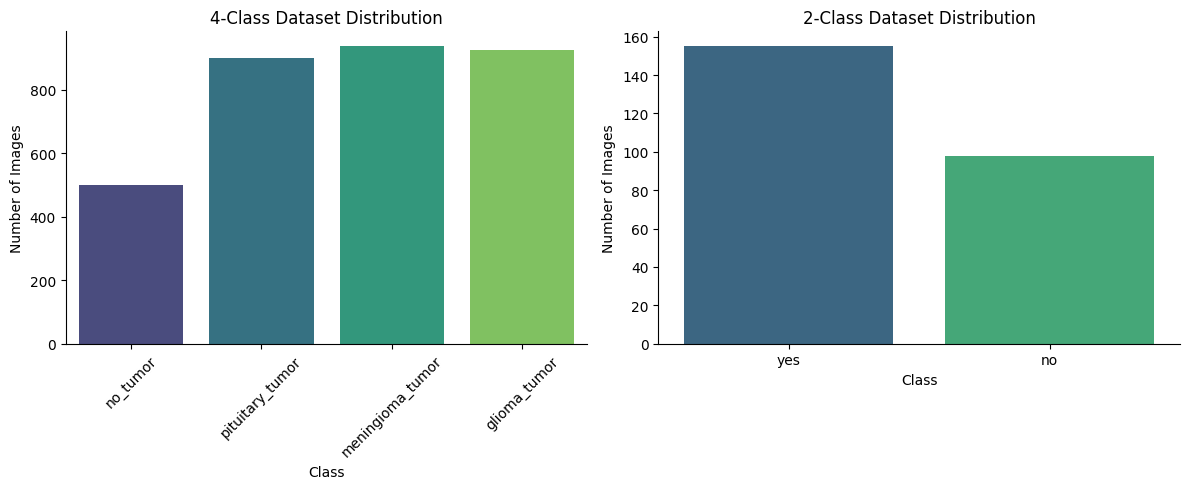

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for 4-class dataset
sns.barplot(x='Class', y='Number of Images', data=df_4class, ax=axes[0],
            hue = 'Class', palette='viridis')
axes[0].set_title('4-Class Dataset Distribution')
axes[0].tick_params(axis='x', rotation=45)
axes[0].spines[['top', 'right',]].set_visible(False)


# Plot for 2-class dataset
sns.barplot(x='Directory', y='Number of Images', data=df_2class, ax=axes[1],
            hue = 'Directory', palette='viridis')
axes[1].set_xlabel('Class')
axes[1].set_title('2-Class Dataset Distribution')
axes[1].spines[['top', 'right',]].set_visible(False)


plt.tight_layout()
plt.show()

### Observations
* 2-Class dataset does not have 5000+ images as listed in the paper. It only has around 250 images.



## SSCLNET Architecture



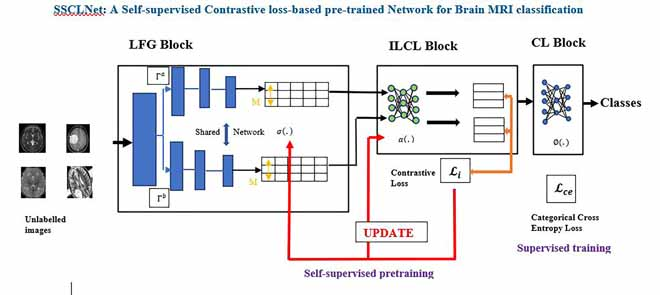

### Core Imports

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import gc
import random
import cv2
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from tensorflow.keras import layers, models, optimizers, metrics, Model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from tensorflow.keras.applications import ResNet50
import datetime, os

### Configurations

In [2]:
BATCH_SIZE = 64
IMG_SIZE = (224, 224)
EMBED_DIM = 32
NUM_CLASSES = 2
SSL_EPOCHS = 100
SUP_EPOCHS = 100
GRAYSCALE = False
LR = 3e-4
TEMPERATURE = 0.5
DROPOUT_RATE = 0.4
AUTOTUNE = tf.data.AUTOTUNE

In [3]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Set your project base directory in Google Drive
BASE_DIR = "/content/drive/MyDrive/Brain_SSL_Project"

# Define subdirectories for organizing outputs
CHECKPOINT_DIR_SSL = os.path.join(BASE_DIR, "checkpoints_ssl")
CHECKPOINT_DIR_SUP = os.path.join(BASE_DIR, "checkpoints_supervised")
LOG_DIR = os.path.join(BASE_DIR, "logs")
MODEL_DIR = os.path.join(BASE_DIR, "models")

# Create directories if they don't exist
os.makedirs(CHECKPOINT_DIR_SSL, exist_ok=True)
os.makedirs(CHECKPOINT_DIR_SUP, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

print("Google Drive mounted successfully.")
print("Project folders created at:", BASE_DIR)


Mounted at /content/drive
Google Drive mounted successfully.
Project folders created at: /content/drive/MyDrive/Brain_SSL_Project


### Dataset Preparation

In [4]:
!pip install -U --no-cache-dir gdown --pre
!gdown https://drive.google.com/uc?id=1RK-qLscrh8WirgwSxOcTbq5_3F3UcpTa
!unzip -o "/content/images_binary.zip" -d /content/


Streaming output truncated to the last 5000 lines.
  inflating: /content/training_images/no@3643.jpg  
  inflating: /content/training_images/yes@521.jpg  
  inflating: /content/training_images/yes@4868.jpg  
  inflating: /content/training_images/no@1084.jpg  
  inflating: /content/training_images/yes@47.jpg  
  inflating: /content/training_images/yes@1030.jpg  
  inflating: /content/training_images/yes@2105.jpg  
  inflating: /content/training_images/yes@2583.jpg  
  inflating: /content/training_images/no@4466.jpg  
  inflating: /content/training_images/yes@1440.jpg  
  inflating: /content/training_images/yes@4907.jpg  
  inflating: /content/training_images/no@4954.jpg  
  inflating: /content/training_images/yes@4948.jpg  
  inflating: /content/training_images/yes@3286.jpg  
  inflating: /content/training_images/yes@645.jpg  
  inflating: /content/training_images/no@1266.jpg  
  inflating: /content/training_images/yes@3273.jpg  
  inflating: /content/training_images/no@846.jpg  
  infl

In [5]:
train_paths = glob('/content/training_images/*.jpg')
test_paths = glob('/content/testing_images/*.jpg')

def get_label_from_path(path):
    # Extract class label from file path.
    return os.path.basename(path).split('@')[0]

train_labels = [get_label_from_path(p) for p in train_paths]
test_labels = [get_label_from_path(p) for p in test_paths]

### Image Preprocessing and Augmentation

In [6]:
def read_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=1 if GRAYSCALE else 3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMG_SIZE)
    return img

def augment_image(image):
    """Random crop, brightness, contrast, noise."""
    augmentations_mode=['Resized Crop','Random Brightness','Random_Contrast','Gaussian Blur']
    aug_mode_idx= random.randint(0,len(augmentations_mode))

    img = image
    if aug_mode_idx==0:
      img = tf.image.random_crop(image, size=[int(IMG_SIZE[0]*0.9), int(IMG_SIZE[1]*0.9), 1 if GRAYSCALE else 3])
      img = tf.image.resize(img, IMG_SIZE)
    if aug_mode_idx==1:
      img = tf.image.random_brightness(img, 0.2)
    if aug_mode_idx==2:
      img = tf.image.random_contrast(img, 0.8, 1.2)
    if aug_mode_idx==3:
      img = img + tf.random.normal(tf.shape(img), stddev=0.01)
      img = tf.clip_by_value(img, 0.0, 1.0)
    return img

def get_ssl_pair(path):
    """Return (aug1, aug2) pair for contrastive learning."""
    img = read_image(path)
    return augment_image(img), augment_image(img)


In [9]:
# Create Dataset for Contrastive Learning
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.map(get_ssl_pair, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [7]:
def make_ssl_dataset(paths, batch_size=BATCH_SIZE, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices(paths)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths))

    ds = ds.map(get_ssl_pair, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.prefetch(AUTOTUNE)
    return ds

### Label Feature Generation (LFG) Block:

Base Encoder (ResNet backbone)

In [8]:
@tf.keras.utils.register_keras_serializable()
class L2Normalize(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.math.l2_normalize(inputs, axis=1)

def build_embedding_network(input_shape=(*IMG_SIZE,3),
                            embedding_dim=EMBED_DIM,
                            dropout_rate=DROPOUT_RATE,
                            use_imagenet_weights=True):
    """
    ResNet50 backbone: convert grayscale to RGB, feed to ResNet50(include_top=False, weights='imagenet'),
    then add four dense layers 512->512->256->256, dropout, and final Dense(embedding_dim).
    Output is L2-normalized embedding.
    """
    inp = layers.Input(shape=input_shape, name="image_input")
    # convert to RGB so we can use ImageNet weights
    #x = tf.image.grayscale_to_rgb(inp)  # now shape (...,3)
    # base ResNet50 pooling='avg' returns (batch, features)
    weights = 'imagenet' if use_imagenet_weights else None
    base = ResNet50(include_top=False, weights=weights, input_tensor=inp, pooling='avg')
    base.trainable = True  # paper trains embedding end-to-end
    h = base.output
    h = layers.Dense(512, activation='relu', name='emb_dense_512_1')(h)
    h = layers.Dense(512, activation='relu', name='emb_dense_512_2')(h)
    h = layers.Dense(256, activation='relu', name='emb_dense_256_1')(h)
    h = layers.Dense(256, activation='relu', name='emb_dense_256_2')(h)
    h = layers.Dropout(dropout_rate, name='emb_dropout')(h)
    emb = layers.Dense(embedding_dim, activation=None, name='embedding_dense')(h)
    emb = L2Normalize(name="embedding_l2norm")(emb)
    model = Model(inputs=inp, outputs=emb, name="EmbeddingNetwork_ResNet50")
    return model

ssl_model = build_embedding_network()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [44]:
ssl_model.load_weights("/content/drive/MyDrive/Brain_SSL_Project/checkpoints_ssl/contrastive_100.weights.h5")

print("✅ Loaded pretrained weights into the fixed architecture.")

✅ Loaded pretrained weights into the fixed architecture.


In [47]:
ssl_model.save("/content/drive/MyDrive/Brain_SSL_Project/checkpoints_ssl/embedding_network_final.keras")

### Instance Level Contrastive Learning (ILCL) Block

In [9]:
class ContrastiveModel(Model):
    def __init__(self, embedding_network, temperature=TEMPERATURE):
        super().__init__()
        self.embedding_network = embedding_network
        self.temperature = temperature
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def compute_paper_loss(self, z_a, z_b):
        """
        Implements equation from paper using z_a and z_b (both L2-normalized).
        z_a, z_b: shape (batch, dim)
        Returns scalar loss L (averaged as in Eq. 2).
        """
        batch_size = tf.shape(z_a)[0]
        # compute similarity matrices (dot-product == cosine because L2-normed)
        logits_aa = tf.matmul(z_a, z_a, transpose_b=True)  # (B,B)
        logits_bb = tf.matmul(z_b, z_b, transpose_b=True)  # (B,B)
        logits_ab = tf.matmul(z_a, z_b, transpose_b=True)  # (B,B)
        logits_ba = tf.matmul(z_b, z_a, transpose_b=True)  # (B,B)

        # scale by temperature
        logits_aa /= self.temperature
        logits_bb /= self.temperature
        logits_ab /= self.temperature
        logits_ba /= self.temperature

        # mask self-similarity on logits_aa and logits_bb by setting diag to -inf
        large_neg = -1e9
        mask = tf.eye(batch_size)
        logits_aa = logits_aa + mask * large_neg
        logits_bb = logits_bb + mask * large_neg

        # For each i, positive for a_i is b_i (same index)
        labels = tf.range(batch_size)

        # Following the paper's eqn: denominator has exp(sim(a_i, b_j)) + exp(sim(a_i, z_j^b))??
        # Implementation matches prior derivation: concat [logits_ab, logits_aa] so positives at position 0..B-1 in logits_ab part.
        logits_for_a = tf.concat([logits_ab, logits_aa], axis=1)  # shape (B, 2B)
        logits_for_b = tf.concat([logits_ba, logits_bb], axis=1)  # shape (B, 2B)

        # compute loss per example using sparse softmax cross entropy: labels are indices of positive (0..B-1)
        loss_a = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits_for_a)
        loss_b = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits_for_b)

        loss = tf.reduce_mean(loss_a + loss_b) / 2.0
        return loss

    def train_step(self, data):
        # data: (x1_batch, x2_batch)
        x1, x2 = data
        with tf.GradientTape() as tape:
            z1 = self.embedding_network(x1, training=True)  # L2-normalized embedding
            z2 = self.embedding_network(x2, training=True)
            loss = self.compute_paper_loss(z1, z2)
        grads = tape.gradient(loss, self.embedding_network.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.embedding_network.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [10]:
def latest_checkpoint_path(checkpoint_dir):
    """Return path to the most recent checkpoint file, or None if none found."""
    ckpts = [os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.endswith(".weights.h5")]
    if not ckpts:
        return None
    return max(ckpts, key=os.path.getctime)

In [25]:
import os, re, datetime, tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping


class EmbeddingWeightsSaver(tf.keras.callbacks.Callback):
    def __init__(self, embedding_network, filepath_template):
        super().__init__()
        self.embedding_network = embedding_network
        self.filepath_template = filepath_template

    def on_epoch_end(self, epoch, logs=None):
        path = self.filepath_template.format(epoch=epoch+1)
        os.makedirs(os.path.dirname(path), exist_ok=True)
        self.embedding_network.save_weights(path)
        print(f"Saved embedding weights to: {path}")


def latest_embedding_weights_path(checkpoint_dir, pattern_prefix="contrastive_", ext=".weights.h5"):
    """Return most recent checkpoint file, or None if none found."""
    if not os.path.exists(checkpoint_dir):
        return None
    ckpts = [os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir)
             if f.startswith(pattern_prefix) and f.endswith(ext)]
    if not ckpts:
        return None
    return max(ckpts, key=os.path.getctime)


def extract_epoch_from_filename(filename):
    """Extract epoch number from 'contrastive_XX.weights.h5'."""
    match = re.search(r"contrastive_(\d+)\.weights\.h5", os.path.basename(filename))
    if match:
        return int(match.group(1))
    return 0


def run_contrastive_pretraining(train_paths,
                                embedding_network,
                                epochs=SSL_EPOCHS,
                                batch_size=BATCH_SIZE,
                                checkpoint_dir=CHECKPOINT_DIR_SSL,
                                lr=LR):
    # Ensure model built
    if not embedding_network.built:
        print("Building embedding network with dummy input...")
        _ = embedding_network(tf.zeros((1, *IMG_SIZE, 3)))
        print("Embedding network built successfully.")

    os.makedirs(checkpoint_dir, exist_ok=True)
    ssl_ds = make_ssl_dataset(train_paths, batch_size=batch_size, shuffle=True)

    contrastive_model = ContrastiveModel(embedding_network=embedding_network, temperature=TEMPERATURE)
    contrastive_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr))

    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    ckpt_template = os.path.join(checkpoint_dir, "contrastive_{epoch:02d}.weights.h5")
    saver_cb = EmbeddingWeightsSaver(embedding_network=embedding_network, filepath_template=ckpt_template)
    csv_logger = CSVLogger(os.path.join(LOG_DIR, f"contrastive_log_{timestamp}.csv"))
    early_stop = EarlyStopping(monitor="loss", patience=10, restore_best_weights=False)

    # Resume from latest checkpoint
    latest_ckpt = latest_embedding_weights_path(checkpoint_dir)
    initial_epoch = 0
    if latest_ckpt:
        print(f"Found latest checkpoint: {latest_ckpt}")
        try:
            embedding_network.load_weights(latest_ckpt)
            initial_epoch = extract_epoch_from_filename(latest_ckpt)
            print(f"Loaded embedding weights (resuming from epoch {initial_epoch+1}).")
        except Exception as e:
            print("Failed to load weights:", e)

    # Continue training from next epoch
    contrastive_model.fit(
        ssl_ds,
        epochs=epochs,
        initial_epoch=initial_epoch,
        callbacks=[saver_cb, csv_logger, early_stop],
        verbose=1
    )

    # Save final embedding network
    final_path = os.path.join(checkpoint_dir, "embedding_network_final.keras")
    embedding_network.save(final_path, include_optimizer=False)
    print(f"Final embedding network saved to {final_path}")

    return contrastive_model


In [26]:
# Contrastive pretraining (resume if checkpoint exists)
run_contrastive_pretraining(train_paths,
                            embedding_network=ssl_model,
                            epochs=SSL_EPOCHS,
                            batch_size=BATCH_SIZE,
                            checkpoint_dir=CHECKPOINT_DIR_SSL,
                            lr=LR)



Found latest checkpoint: /content/drive/MyDrive/Brain_SSL_Project/checkpoints_ssl/contrastive_80.weights.h5
Loaded embedding weights (resuming from epoch 81).
Epoch 81/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 3.1706Saved embedding weights to: /content/drive/MyDrive/Brain_SSL_Project/checkpoints_ssl/contrastive_81.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - loss: 3.1700
Epoch 82/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 3.0804Saved embedding weights to: /content/drive/MyDrive/Brain_SSL_Project/checkpoints_ssl/contrastive_82.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - loss: 3.0803
Epoch 83/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 3.0753Saved embedding weights to: /content/drive/MyDrive/Brain_SSL_Project/checkpoints_ssl/contrastive_83.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - loss: 3.0752
Epoch 84/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 3.0649Saved embedding weights to: /content/drive/MyDrive/Brain_SSL_Project/checkpoints_ssl/

<ContrastiveModel name=contrastive_model, built=False>

### Classification (CL) Block

In [11]:
# ------------------ Utility: extract embeddings from embedding network ------------------
def extract_embeddings(embedding_network, paths, batch_size=128):
    """
    Uses the pretrained embedding network to generate representations for each image.
    """
    ds = tf.data.Dataset.from_tensor_slices(paths)
    ds = ds.map(read_image, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)

    print("Extracting embeddings from pretrained SSL network...")
    embs = embedding_network.predict(ds, verbose=1)
    print(f"Extracted embeddings: {embs.shape}")
    return embs  # shape (n_samples, EMBED_DIM)


# ------------------ Supervised training on extracted embeddings ------------------
def run_supervised_on_embeddings(
    X_train_emb,
    y_train,
    X_val_emb,
    y_val,
    checkpoint_dir=CHECKPOINT_DIR_SUP,
    lr=1e-3,
    epochs=SUP_EPOCHS,
):
    """
    Builds and trains the supervised classification model described in the paper:
    Dense layers: 256 → 256 → 128 → 128 → 64 → 32 → 16 → Softmax(classes)
    Inputs: embeddings from the pretrained SSL embedding network.
    """

    # Ensure checkpoint directory exists
    os.makedirs(checkpoint_dir, exist_ok=True)

    # ------------------ Architecture per paper ------------------
    inp = tf.keras.Input(shape=(EMBED_DIM,), name="embedding_input")

    x = tf.keras.layers.Dense(256, activation="relu")(inp)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.Dense(32, activation="relu")(x)
    x = tf.keras.layers.Dense(16, activation="relu")(x)

    out = tf.keras.layers.Dense(y_train.shape[1], activation="softmax", name="class_output")(x)

    clf = tf.keras.Model(inputs=inp, outputs=out, name="SupervisedClassifier")

    # ------------------ Compilation ------------------
    clf.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    # ------------------ Callbacks ------------------
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    # Use Keras recommended format (.keras)
    ckpt_filepath = os.path.join(checkpoint_dir, "supervised_{epoch:02d}.weights.h5")

    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=ckpt_filepath,
        save_weights_only=True,
        save_freq="epoch",
        verbose=1,
    )

    csv_logger = tf.keras.callbacks.CSVLogger(
        os.path.join(LOG_DIR, f"supervised_log_{timestamp}.csv")
    )

    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )

    # ------------------ Resume from checkpoint ------------------
    latest_ckpt = latest_checkpoint_path(checkpoint_dir)
    if latest_ckpt:
        try:
            clf.load_weights(latest_ckpt)
            print(f"Loaded classifier weights from {latest_ckpt}")
        except Exception as e:
            print(f"Failed to load classifier weights: {e}")

    # ------------------ Training ------------------
    print("Starting supervised fine-tuning...")
    history = clf.fit(
        X_train_emb,
        y_train,
        validation_data=(X_val_emb, y_val),
        epochs=epochs,
        batch_size=32,
        callbacks=[checkpoint_cb, csv_logger, early_stop],
        verbose=1,
    )

    # ------------------ Save final model ------------------
    final_classifier_path = os.path.join(checkpoint_dir, "classifier_final.keras")
    clf.save(final_classifier_path)
    print(f"Saved final classifier to {final_classifier_path}")

    return clf, history


In [12]:
# Load the pretrained embedding model from saved file
from tensorflow.keras.models import load_model

embedding_model_path = "/content/drive/MyDrive/Brain_SSL_Project/checkpoints_ssl/embedding_network_final.keras"

print(" Loading pretrained embedding network...")
embedding_network = load_model(
    embedding_model_path,
    compile=False,
    safe_mode=False)
print(" Embedding network loaded successfully.")
embedding_network.summary()


 Loading pretrained embedding network...
 Embedding network loaded successfully.


Model: "EmbeddingNetwork_ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ image_input[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,104,800 (95.77 MB)

 Trainable params: 25,051,680 (95.56 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [13]:
# Extract embeddings for training and validation sets
X_train_emb = extract_embeddings(embedding_network, train_paths)
X_test_emb   = extract_embeddings(embedding_network, test_paths)


Extracting embeddings from pretrained SSL network...
41/41 ━━━━━━━━━━━━━━━━━━━━ 689s 17s/step
Extracted embeddings: (5141, 32)
Extracting embeddings from pretrained SSL network...
11/11 ━━━━━━━━━━━━━━━━━━━━ 175s 16s/step
Extracted embeddings: (1285, 32)


In [14]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# Create encoder and fit on all labels (train + test)
label_encoder = LabelEncoder()
label_encoder.fit(train_labels + test_labels)  # combine both to cover all classes

# Convert string labels to integers
y_train_int = label_encoder.transform(train_labels)
y_test_int  = label_encoder.transform(test_labels)

# One-hot encode the integer labels
NUM_CLASSES = len(label_encoder.classes_)
y_train = tf.keras.utils.to_categorical(y_train_int, num_classes=NUM_CLASSES)
y_test  = tf.keras.utils.to_categorical(y_test_int,  num_classes=NUM_CLASSES)

print("✅ Encoded classes:", label_encoder.classes_)


✅ Encoded classes: ['no' 'yes']


In [16]:
clf, hist = run_supervised_on_embeddings(
    X_train_emb, y_train,
    X_test_emb, y_test,
    checkpoint_dir=CHECKPOINT_DIR_SUP,
    lr=1e-4,
    epochs=SUP_EPOCHS
)

Loaded classifier weights from /content/drive/MyDrive/Brain_SSL_Project/checkpoints_supervised/supervised_09.weights.h5
Starting supervised fine-tuning...
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


154/161 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7365 - loss: 0.5215
Epoch 1: saving model to /content/drive/MyDrive/Brain_SSL_Project/checkpoints_supervised/supervised_01.weights.h5
161/161 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7364 - loss: 0.5216 - val_accuracy: 0.7276 - val_loss: 0.5368
Epoch 2/100
151/161 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7361 - loss: 0.5153
Epoch 2: saving model to /content/drive/MyDrive/Brain_SSL_Project/checkpoints_supervised/supervised_02.weights.h5
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7363 - loss: 0.5155 - val_accuracy: 0.7362 - val_loss: 0.5317
Epoch 3/100
146/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7306 - loss: 0.5212
Epoch 3: saving model to /content/drive/MyDrive/Brain_SSL_Project/checkpoints_supervised/supervised_03.weights.h5
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7308 - loss: 0.5212 - val_accuracy: 0.7261 - val_loss: 0.5343
Epoch 4/100
159/161 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - 

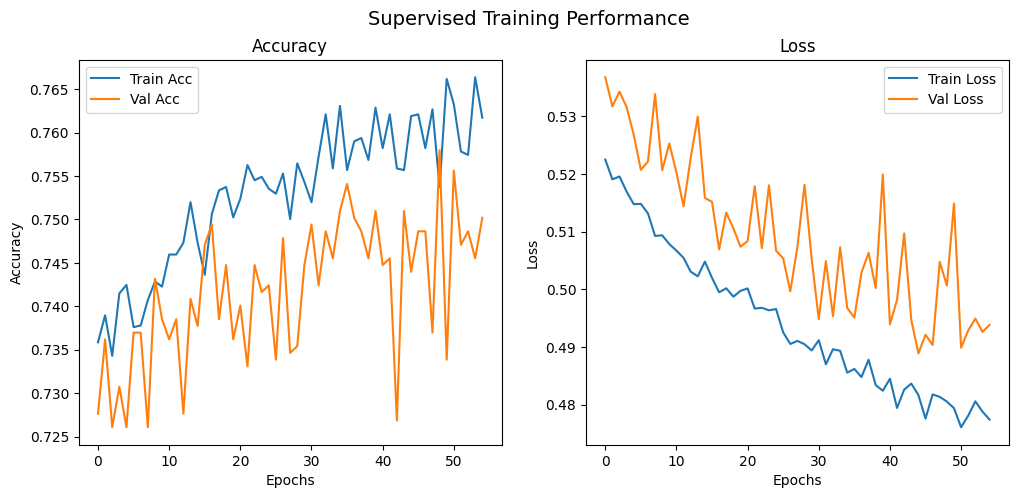

In [18]:
import matplotlib.pyplot as plt

def plot_training_curves(history, title="Supervised Training Performance"):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Acc")
    plt.plot(history.history["val_accuracy"], label="Val Acc")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.suptitle(title, fontsize=14)
    plt.show()


plot_training_curves(hist)

### Evaluation

In [ ]:
preds = classifier.predict(X_test)
pred_labels = np.argmax(preds, axis=1)
true_labels = np.argmax(y_test, axis=1)
